# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Image Caption Generator</b></div>

---

## **What is Image Captioning?**

- Image Captioning is the process of automatically generating a textual description for a given image.  
- It’s a fascinating blend of **Computer Vision** and **Natural Language Processing (NLP)** that enables machines to “see” and “talk” about what they observe.
- Most modern captioning systems use an **Encoder-Decoder architecture**, where an image is first encoded into a dense vector representation and then decoded into a sentence that describes the image content.

---

## **Visiong Transformer (ViT)**
<br>

<div align='center'>
<img src="https://thepythoncode.com/media/articles/image-captioning-with-pytorch-and-transformers-in-python/vision-encoder-decoder.png">
</div>
<br>

- Vision Transformers adapt the transformer model—originally designed for NLP—to process images by treating image patches as tokens.
- Images are divided into fixed-size patches, which are then flattened and embedded, allowing the model to learn relationships between different regions via self-attention.
- Although ViTs tend to require large datasets for training to achieve competitive performance, they have demonstrated state-of-the-art results in various computer vision tasks.

<div align='center'>
    <img src='https://miro.medium.com/v2/resize:fit:1100/0*mCHDMNdwb_gB1Rj9.'>
</div>

# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Project and Team</b></div>

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKzG04aVsH3CPLHLScCTg6RxTs4qeouSN52g&s" alt="Project Banner" style="width:100%; border-radius:10px; margin:20px 0"/>

This Image Caption Generator is a **Graduation Project** developed as part of the  
**Digital Egypt Pioneers Initiative – AI & Data Science Track (Microsoft Machine Learning Engineer)**.

> A fully-funded initiative provided by the **Ministry of Communications and Information Technology (MCIT)** for students and graduates from all universities and colleges across Egypt.

---

## 📘 Track Curriculum Overview

The track covers a wide variety of topics over 20 weeks:

- **Mathematics & Python**: Statistics, Linear Algebra, Data Structures, OOP  
- **Data Preprocessing & Visualization**: NumPy, Pandas, Seaborn, Real-world projects  
- **Machine Learning**: Regression, Classification, Model Evaluation, Ensemble Methods  
- **Deep Learning**: Neural Networks, TensorFlow, Regularization, Optimization  
- **Natural Language Processing**: RNNs, LSTMs, Transformers, Attention Mechanisms  
- **Computer Vision**: CNNs, Transfer Learning, Object Detection (YOLO, RCNN), GANs  
- **Azure AI Services**: Fundamentals of AI, Computer Vision, NLP on Azure  
- **MLOps**: Introduction to MLFlow and deployment tools

---

## 👥 Team Members

**Ahmed El-Hefnawy, Ahmed El-Tokhey, Samir Mohamed, Ahmed Adel, Amr Ghanem**


# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Installing Dependencies</b></div>

<br>

<div align='center'>
    <img src='https://blog.accredian.com/wp-content/uploads/2019/05/10-Python-packages-and-libraries-you-absolutely-have-to-ace.png'>
</div>

In [1]:
# !pip install transformers -q

In [2]:
import os
import re
import gc
import json
import collections
import math
import random                                                                   
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K
import tf_keras    # Problem with tf.keras requires tf version 2.15.1

from PIL import Image
from tokenizers import BertWordPieceTokenizer, Tokenizer
from sklearn.model_selection import train_test_split
from tf_keras.layers.experimental.preprocessing import StringLookup
from tf_keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

2025-05-05 18:08:38.561637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746468518.731953      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746468518.781012      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Configure GPU Usage & Clear Memory Cache</b></div>

<br>

<div align='center'>
    <img src='https://media.licdn.com/dms/image/v2/D5612AQF_j9tHlYdm2Q/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1707322917888?e=2147483647&v=beta&t=7IT0rWIDLWyW4NWHUMkgQyOPb1WVIGxnUb6HG6Vu8pM'>
</div>

In [3]:
# Configure TensorFlow to use GPU by default
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

In [4]:
def clear_cache():
    """
    Clears memory cache using garbage collector and TensorFlow backend clear session
    """
    # Clear TensorFlow session and free memory
    K.clear_session()
    
    # Run garbage collector
    gc.collect()


# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Loading The Dataset And Preprocessing</b></div>

<br>

<div align='center'>
    <img src='https://yingqianwang.github.io/Flickr1024/pics/Sample%20Images.jpg'>
</div>

<br>

### 🎞️ Flicker Image Dataset.
---
- We used Flick Image Dataset with 30k images with about 5 captions descriping each image.

In [5]:
BASE_DIR = "/kaggle/input/flickr-image-dataset/flickr30k_images"
WORK_DIR = "/kaggle/working"

os.listdir(BASE_DIR)

['flickr30k_images', 'results.csv']

In [6]:
# Reading the results file.
df = pd.read_csv(f"{BASE_DIR}/results.csv", sep='|', names=['image_name', 'comment_number', 'comment'])

In [7]:
df.head()

image_name   comment_number  \
0      image_name   comment_number   
1  1000092795.jpg                0   
2  1000092795.jpg                1   
3  1000092795.jpg                2   
4  1000092795.jpg                3   

                                             comment  
0                                            comment  
1   Two young guys with shaggy hair look at their...  
2   Two young , White males are outside near many...  
3   Two men in green shirts are standing in a yard .  
4       A man in a blue shirt standing in a garden .

#### 🎞️ Cleaning the dataset and displaying its information.
---

In [8]:
df = df.drop(columns=['comment_number'])
df = df.drop(index=0).reset_index(drop=True)
df = df.rename(columns={'comment' : 'caption'})

In [9]:
df.head()

image_name                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  158915 non-null  object
 1   caption     158914 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [11]:
df.describe()

image_name                          caption
count          158915                           158914
unique          31783                           158438
top     998845445.jpg   Two dogs playing in the snow .
freq                5                                7

In [12]:
df.isnull().sum()

image_name    0
caption       1
dtype: int64

In [13]:
# Deleting null values
df.dropna(inplace=True)

In [14]:
df.isnull().sum()

image_name    0
caption       0
dtype: int64

In [15]:
df['processed_caption'] = "[START] " + df['caption'].str.lower().apply(lambda x: re.sub(r"[^\w\s]", '', x)).str.strip() + " [END]"
df['image_filepath'] = df['image_name'].apply(
    lambda x: os.path.join(BASE_DIR, "flickr30k_images", x)
)

In [16]:
df.head()

image_name                                            caption  \
0  1000092795.jpg   Two young guys with shaggy hair look at their...   
1  1000092795.jpg   Two young , White males are outside near many...   
2  1000092795.jpg   Two men in green shirts are standing in a yard .   
3  1000092795.jpg       A man in a blue shirt standing in a garden .   
4  1000092795.jpg            Two friends enjoy time spent together .   

                                   processed_caption  \
0  [START] two young guys with shaggy hair look a...   
1  [START] two young  white males are outside nea...   
2  [START] two men in green shirts are standing i...   
3  [START] a man in a blue shirt standing in a ga...   
4  [START] two friends enjoy time spent together ...   

                                      image_filepath  
0  /kaggle/input/flickr-image-dataset/flickr30k_i...  
1  /kaggle/input/flickr-image-dataset/flickr30k_i...  
2  /kaggle/input/flickr-image-dataset/flickr30k_i...  
3  /kaggle/input/flickr-image-dataset/flickr30k_i...  
4  /kaggle/input/flickr-image-dataset/flickr30k_i...

### 🎞️ Splitting the dataset into (Train, Validation, Test).
---

In [17]:
# Step 1: Get unique image names
unique_images = df['image_name'].unique()

# Step 2: Split into train (80%) and temp (20%)
train_images, temp_images = train_test_split(unique_images, test_size=0.2, random_state=42)

# Step 3: Split temp into validation (10%) and test (10%)
valid_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

# Step 4: Filter the DataFrame
train_df = df[df['image_name'].isin(train_images)]
valid_df = df[df['image_name'].isin(valid_images)]
test_df = df[df['image_name'].isin(test_images)]

### 🎞️ Displaying some images of the Dataset.
---

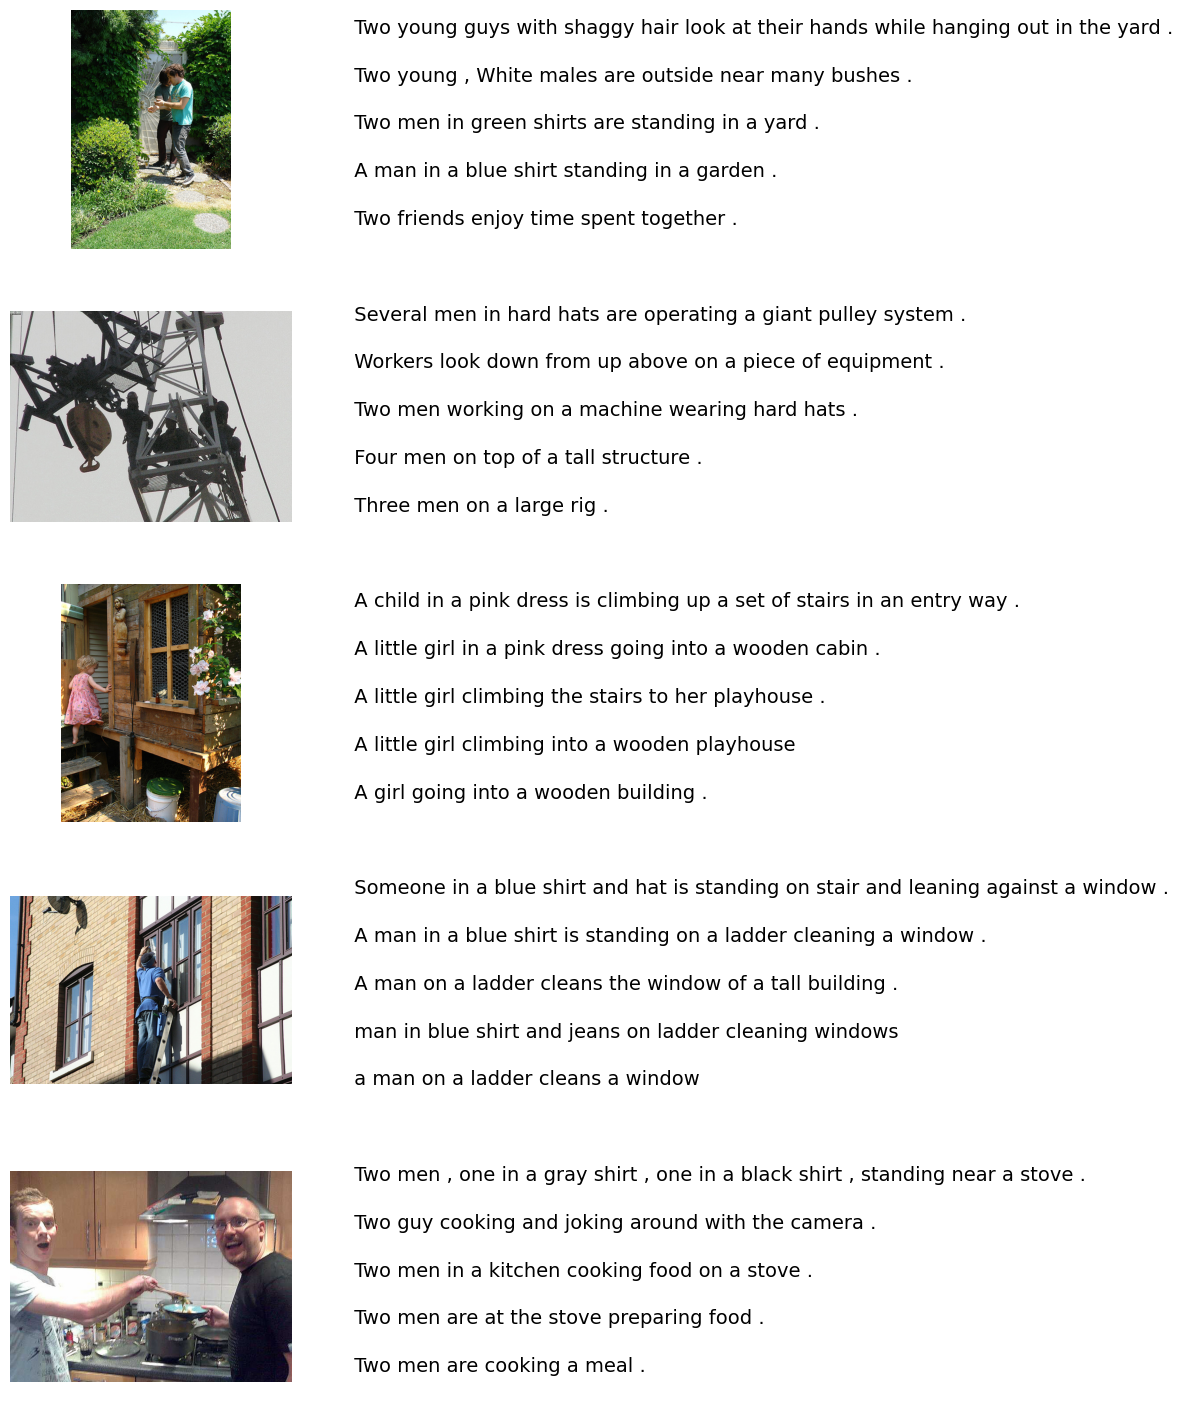

In [18]:
sample_data = train_df.groupby('image_name')['caption'].agg(list).iloc[:5]

fig, axes = plt.subplots(5, 2, figsize=(8, 18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    
    ax_row[0].imshow(Image.open(os.path.join(BASE_DIR, "flickr30k_images", index)))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

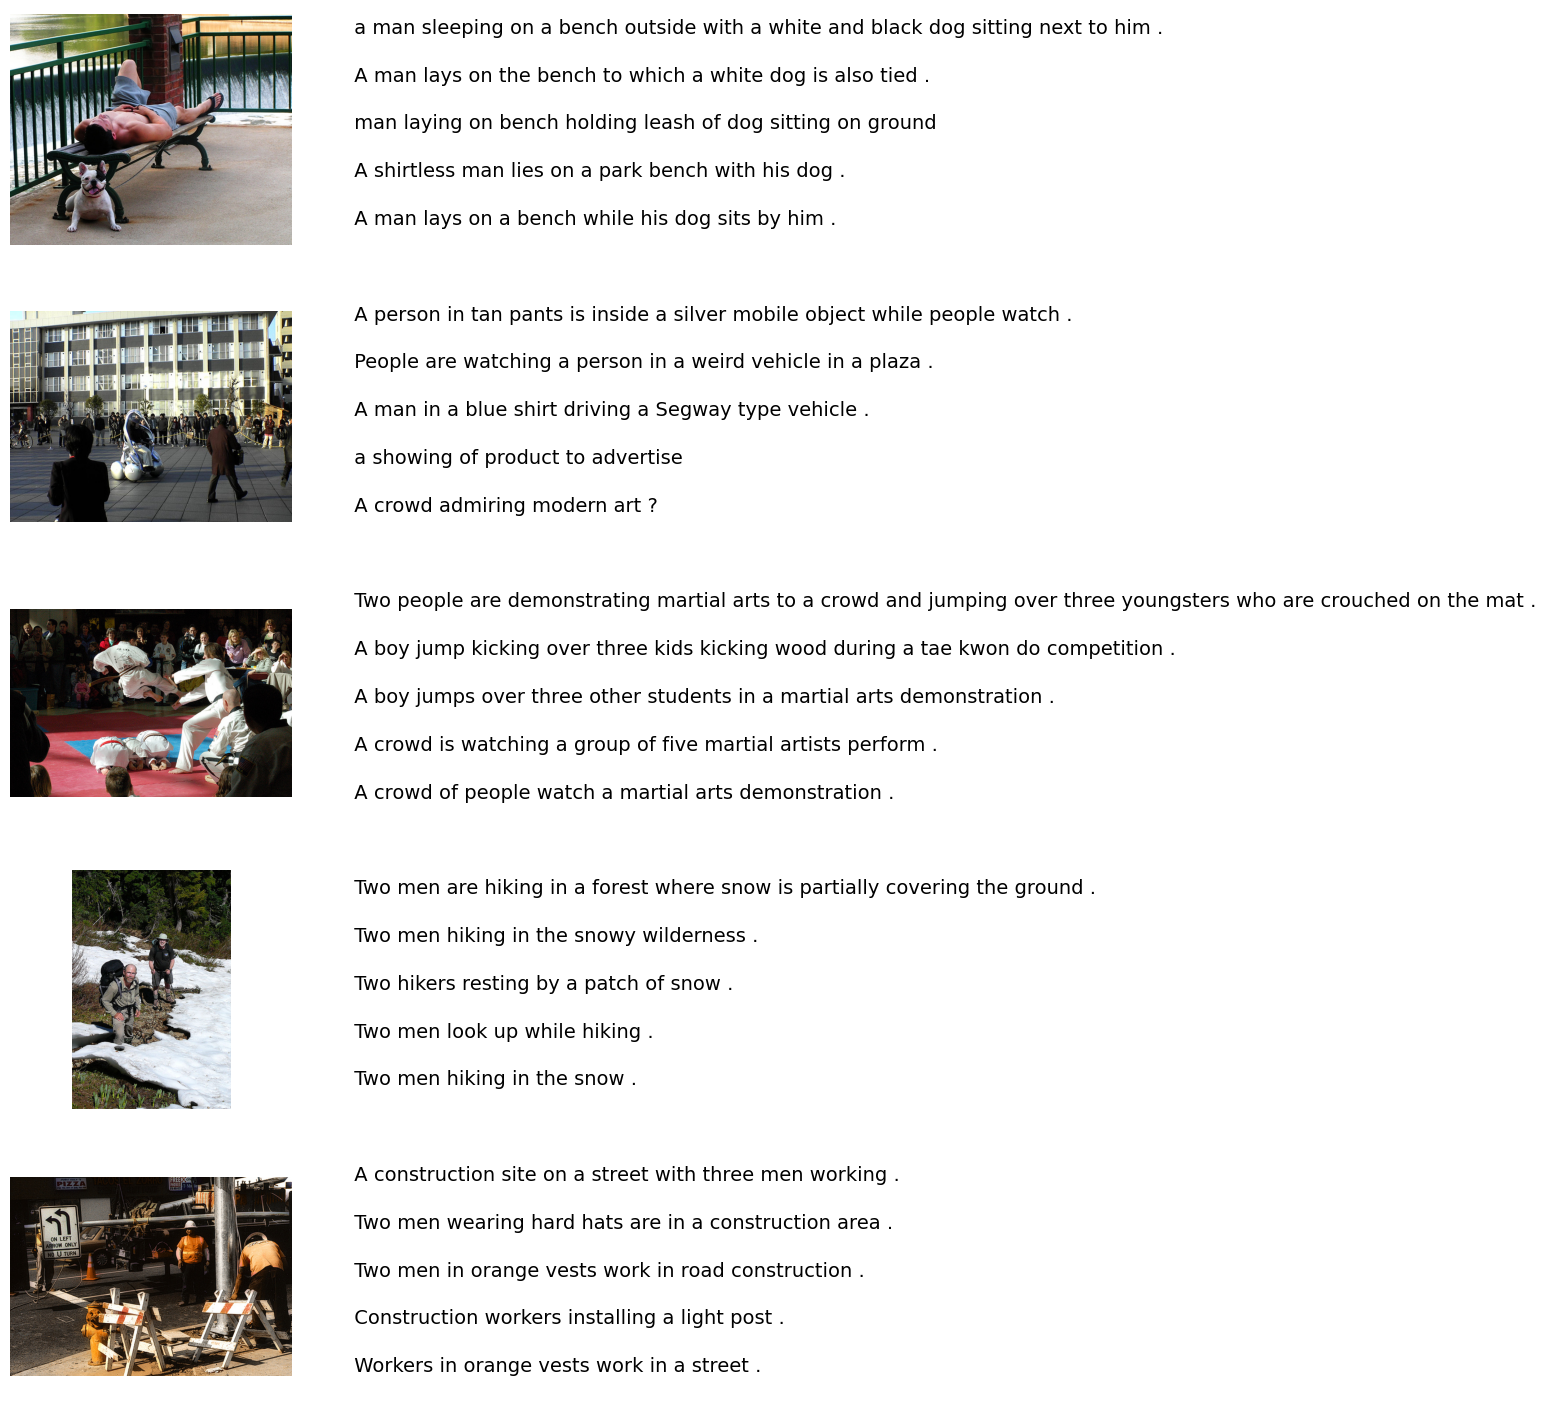

In [19]:
sample_data = test_df.groupby('image_name')['caption'].agg(list).iloc[:5]

fig, axes = plt.subplots(5, 2, figsize=(8, 18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    
    ax_row[0].imshow(Image.open(os.path.join(BASE_DIR, "flickr30k_images", index)))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Tokenizing The Captions Of The Images</b></div>

<div align='center'>
    <img src='https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/tokenization_pipeline.svg'>
</div>

### 🛠️ BERT Tokenizer.
---
 - BERT Tokenizer is used here, to **tokenize captions** such that it is used in models.
 - There are reserved words like **[START]**, **[END]** which are used to inform the model the start and the end of the sentence.
 - There are other special tokens like **[PAD], [UNK], [CLS], [MASK], [SEP]** which are used for special purposes in the process of tokenization.

#### 🛠️ Here we got only words that appeared 15 times or more to remove non frequent words.
---

In [20]:
train_vocabulary = train_df["processed_caption"].str.split(" ").explode().value_counts()
vocab_num = len(train_vocabulary[train_vocabulary>=15])  # Word found 15 times or more.
print(vocab_num)

3896


#### 🛠️ Initializing the BERT Tokenizer.
---

In [21]:
def generate_tokenizer(captions_df, n_vocab):
    """ Generate the tokenizer with given captions """
    
    # Define the tokenizer
    tokenizer = BertWordPieceTokenizer(
        unk_token="[UNK]",
        clean_text=False,
        lowercase=False,
    )
    
    # Train the tokenizer
    tokenizer.train_from_iterator(
        captions_df["processed_caption"].tolist(),
        vocab_size=n_vocab,
        special_tokens=["[PAD]", "[UNK]", "[START]", "[END]", "[CLS]", "[MASK]", "[SEP]"]
    )
    
    return tokenizer

#### 🛠️ Encoding the Captions.
---

In [22]:
# Encoding a sentence
tokenizer = generate_tokenizer(train_df, vocab_num)
example_captions = valid_df["processed_caption"].iloc[:5].tolist()
example_tokenized_captions = tokenizer.encode_batch(example_captions)

for caption, tokenized_cap in zip(example_captions, example_tokenized_captions):
    print(f"{caption} \n {tokenized_cap.tokens}\n\n")




[START] a man sits in a chair while holding a large stuffed animal of a lion [END] 
 ['[START]', 'a', 'man', 'sits', 'in', 'a', 'chair', 'while', 'holding', 'a', 'large', 'stuffed', 'animal', 'of', 'a', 'li', '##on', '[END]']


[START] a man is sitting on a chair holding a large stuffed animal [END] 
 ['[START]', 'a', 'man', 'is', 'sitting', 'on', 'a', 'chair', 'holding', 'a', 'large', 'stuffed', 'animal', '[END]']


[START] a man completes the finishing touches on a stuffed lion [END] 
 ['[START]', 'a', 'man', 'comple', '##tes', 'the', 'finish', '##ing', 'touch', '##es', 'on', 'a', 'stuffed', 'li', '##on', '[END]']


[START] a man holds a large stuffed lion toy [END] 
 ['[START]', 'a', 'man', 'holds', 'a', 'large', 'stuffed', 'li', '##on', 'toy', '[END]']


[START] a man is smiling at a stuffed lion [END] 
 ['[START]', 'a', 'man', 'is', 'smiling', 'at', 'a', 'stuffed', 'li', '##on', '[END]']




In [23]:
tokenizer.save(f"{WORK_DIR}/ViTBertTokenizer")

In [24]:
vocab = tokenizer.get_vocab()

for token in ["[PAD]", "[UNK]", "[START]", "[END]", "[CLS]", "[MASK]", "[SEP]"]:
    print(f"{token} -> {vocab[token]}")

[PAD] -> 0
[UNK] -> 1
[START] -> 2
[END] -> 3
[CLS] -> 4
[MASK] -> 5
[SEP] -> 6


# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Preprocessing The Images</b></div>

<br>
<div align='center'>
    <img src='https://www.befunky.com/images/prismic/bd1c3b35-14f5-4a8c-9de5-45e4a22befbe_how-to_resize-image-27.svg'>
</div>

---

### 📸 Preprocessing the images to be suitable for ViT model.
---
- Vision Transformer requires all the images to be fixed size 224 * 224, as it dividing each image into patches after that.

#### 📸 This function is used later to unify all the heights and widths of all images to 224 * 224 which is prefered for the Vision Transformer as declared in their paper.
---

In [25]:
def parse_image(filepath, resize_height, resize_width):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [resize_height, resize_width])
    image = image * 2.0 - 1.0
    return image

#### 📸 Here, concatenating paresed images with processed captions and truncating long captions as well as padding small ones.
---

In [26]:
def generate_tf_dataset(image_captions_df, tokenizer=None, n_vocab=vocab_num, pad_length=33, batch_size=32, training=False):
    """ Generate the tf.data.Dataset"""
    
    # If the tokenizer is not available, create one
    if not tokenizer:
        tokenizer = generate_tokenizer(image_captions_df, n_vocab)
        
    # Get the caption IDs using the tokenizer
    image_captions_df["caption_token_ids"] = [enc.ids for enc in tokenizer.encode_batch(image_captions_df["processed_caption"])]
    
    vocab = tokenizer.get_vocab()
    
    # Add the padding to short sentences and truncate long ones
    image_captions_df["caption_token_ids"] = image_captions_df["caption_token_ids"].apply(
        lambda x: x+[vocab["[PAD]"]]*(pad_length - len(x) + 2) if pad_length + 2 >= len(x) else x[:pad_length + 1] + [x[-1]]
    ) 
    
    # Create a dataset with images and captions
    dataset = tf.data.Dataset.from_tensor_slices({
        "image_filepath": image_captions_df["image_filepath"],
        "caption_token_ids": np.array(image_captions_df["caption_token_ids"].tolist())
    })
    
    # Each sample in our dataset consists of
    # (image, caption token IDs, position IDs), (caption token IDs offset by 1)
    dataset = dataset.map(
        lambda x: (
            (parse_image(x["image_filepath"], 224, 224), x["caption_token_ids"][:-1], tf.range(pad_length+1, dtype='float32')), x["caption_token_ids"]
        )
    )
    
    # Shuffle and batch data in the training mode
    if training:
        dataset = dataset.shuffle(buffer_size=batch_size*10)
    
    dataset = dataset.batch(batch_size)
    
    return dataset, tokenizer

In [27]:
batch_size=2
sample_dataset, sample_tokenizer = generate_tf_dataset(train_df, n_vocab=vocab_num, pad_length=74, batch_size=batch_size, training=True)
for i in sample_dataset.take(1):
    print(i)

I0000 00:00:1746468542.687611      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


((<tf.Tensor: shape=(2, 224, 224, 3), dtype=float32, numpy=
array([[[[-0.13851911,  0.3022585 ,  0.7474011 ],
         [-0.14628357,  0.29203117,  0.7390901 ],
         [-0.16240877,  0.29188585,  0.73333347],
         ...,
         [-0.44867104, -0.20041156,  0.04430509],
         [ 0.2971313 ,  0.3062985 ,  0.3955047 ],
         [-0.3963266 , -0.41303527, -0.37230986]],

        [[-0.11742252,  0.28798068,  0.7436961 ],
         [-0.12378258,  0.3071015 ,  0.75502944],
         [-0.15179348,  0.30315912,  0.744323  ],
         ...,
         [ 0.08616817,  0.10234475,  0.28207898],
         [-0.5746553 , -0.62132263, -0.6153151 ],
         [ 0.08155406,  0.01893449,  0.06936002]],

        [[-0.17452848,  0.2930715 ,  0.7295338 ],
         [-0.1450786 ,  0.2969985 ,  0.7404033 ],
         [-0.14833629,  0.30095577,  0.7422271 ],
         ...,
         [-0.5273228 , -0.58688235, -0.5283247 ],
         [ 0.11778343, -0.0030216 ,  0.03771138],
         [-0.23456943, -0.29663968, -0.25026

# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Building The Model</b></div>

<br>

<div align='center'>
    <img src='https://miro.medium.com/v2/resize:fit:1400/1*z-TEUQ9jfIa5iW8I6ssPew.png'>
</div>

<br>

### 🤖ViT Model.
--- 
- The steps of ViT are: dividing the image into fixed-size pathches (almost 16*16), embedding each of them, then using the transformer decoder.
- The decoder layer is used to understand the relation between extracted features and captions using the attention mechanism.

#### 🤖 Building the decoder layer which includes attention mechanism using the **Key, Quary, and Value** vectors.
---

In [30]:
class SelfAttentionLayer(tf_keras.layers.Layer):
    """ Defines the computations in the self attention layer """
    
    def __init__(self, d):        
        super(SelfAttentionLayer, self).__init__()
        # Feature dimensionality of the output
        self.d = d
    
    def build(self, input_shape):
        # Query weight matrix
        self.Wq = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )        
        # Key weight matrix
        self.Wk = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Value weight matrix
        self.Wv = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
    
    def call(self, q_x, k_x, v_x, mask=None):
        
        q = tf.matmul(q_x,self.Wq) #[None, t, d]
        k = tf.matmul(k_x,self.Wk) #[None, t, d]
        v = tf.matmul(v_x,self.Wv) #[None, t, d]
        
        # Computing the final output
        h = tf_keras.layers.Attention(causal=True)([
            q, #q
            v, #v
            k, #k
        ], mask=[None, mask]) # [None, t, t] . [None, t, d] => [None, t, d]
        
        return h
    
class TransformerDecoderLayer(tf_keras.layers.Layer):
    """ The Decoder layer """
    
    def __init__(self, d, n_heads):
        super().__init__()
        
        # Feature dimensionality
        self.d = d
        
        # Dimensionality of a head
        self.d_head = int(d/n_heads) 
        
        # Number of heads
        self.n_heads = n_heads
        
        # Actual attention heads
        self.attn_heads = [SelfAttentionLayer(self.d_head) for _ in range(self.n_heads)]
        
        # Fully connected layers
        self.fc1_layer = tf_keras.layers.Dense(512, activation='relu')
        self.fc2_layer = tf_keras.layers.Dense(d)
        
        self.add_layer = tf_keras.layers.Add()
        self.norm1_layer = tf_keras.layers.LayerNormalization()
        self.norm2_layer = tf_keras.layers.LayerNormalization()
        
    
    def _compute_multihead_output(self, x):
        """ Computing the multi head attention output"""
        outputs = [head(x, x, x) for head in self.attn_heads]            
        outputs = tf.concat(outputs, axis=-1)
        return outputs
        
    def call(self, x):
        
        
        # Multi head attention layer output
        h1 = self._compute_multihead_output(x)
        
        h1_add = self.add_layer([x, h1])
        h1_norm = self.norm1_layer(h1_add)
        
        # Fully connected outputs
        h2_1 = self.fc1_layer(h1_norm)
        h2_2 = self.fc2_layer(h2_1)
        
        h2_add = self.add_layer([h1, h2_2])
        h2_norm = self.norm2_layer(h2_add)
        
        
        return h2_norm

class PositionalEncoding(tf_keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        # we’ll use this constant for the denominator exponent
        self._inv_freq = 1.0 / tf.pow(10000.0, (2 * tf.range(d_model, dtype=tf.float32) // 2) / tf.cast(d_model, tf.float32))

    def call(self, inputs):
        """
        inputs: int tensor of shape (batch_size, seq_len)
        """
        # shape: (seq_len,)
        seq_len = tf.shape(inputs)[1]
        pos = tf.cast(tf.range(seq_len), tf.float32)  # (seq_len,)

        # outer product: (seq_len, d_model)
        angles = tf.expand_dims(pos, -1) * tf.expand_dims(self._inv_freq, 0)

        # apply sin on even indices, cos on odd indices
        # exactly the same decision logic as your tf.where with mod 2
        pos_encoding = tf.where(
            tf.cast(tf.range(self.d_model) % 2, tf.bool)[tf.newaxis, :],
            tf.cos(angles),
            tf.sin(angles)
        )
        # expand to (1, seq_len, d_model) and tile to batch
        batch_size = tf.shape(inputs)[0]
        pos_encoding = tf.tile(pos_encoding[tf.newaxis, ...], [batch_size, 1, 1])
        return pos_encoding

#### 🤖 Building the Final model.
---

In [33]:
# Clear previous sessions
K.clear_session()

# Constants
IMAGE_SHAPE = (224, 224, 3)
D_MODEL = 384
NUM_HEADS = 6  # Because 384/6 = 64
NUM_LAYERS = 4
VOCAB_SIZE = len(tokenizer.get_vocab())  # Assumes tokenizer is already defined

# === Inputs ===
image_input = tf_keras.layers.Input(shape=IMAGE_SHAPE, name='image_input')
caption_input = tf_keras.layers.Input(shape=(None,), name='caption_input')
position_input = tf_keras.layers.Input(shape=(None,), name='position_input')

# === Vision Transformer Encoder (Pretrained, frozen) ===
vit_encoder = tf_keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-s16-fe/1", trainable=False)
])
image_features = vit_encoder(image_input)


print("Encoder Done")

# === Token Embeddings ===
token_embedding = tf_keras.layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=D_MODEL,
    mask_zero=True,
    name="token_embedding"
)

position_embedding = PositionalEncoding(D_MODEL)

# === Combine Token + Positional Embeddings ===
token_embeddings = token_embedding(caption_input)
pos_embeddings = position_embedding(position_input)
caption_embeddings = token_embeddings + pos_embeddings

# === Concatenate Image Features with Caption Embeddings ===
image_features_expanded = tf.expand_dims(image_features, axis=1)
combined_embeddings = tf_keras.layers.Concatenate(axis=1, name='image_caption_concat')([image_features_expanded, caption_embeddings])

# === Transformer Decoder Layers ===
x = combined_embeddings
for i in range(NUM_LAYERS):
    x = TransformerDecoderLayer(D_MODEL, D_MODEL // NUM_HEADS)(x)

# === Final Output ===
final_output = tf_keras.layers.Dense(VOCAB_SIZE, activation='softmax', name='output')(x)

# === Model Definition ===
full_model = tf_keras.models.Model(
    inputs=[image_input, caption_input, position_input],
    outputs=final_output,
    name="vision_transformer_caption_model"
)

# === Compilation ===
full_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# === Summary ===
full_model.summary()


Encoder Done
Model: "vision_transformer_caption_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 caption_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 position_input (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 sequential (Sequential)     (None, 384)              

# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>BLEU Metric</b></div>

<br>

<div align='center'>
    <img src='https://miro.medium.com/v2/resize:fit:1400/1*6kuWTNHeLTAjY9FlYRe0Jg.png'>
</div>

<br>

### 📏 BLEU Metric.
--- 
- BLEU (Bilingual Evaluation Understudy) is a metric used to evaluate the quality of machine-generated text by comparing it to one or more reference texts.
- It calculates the overlap of n-grams between the candidate and reference sentences, rewarding precision.
- BLEU is widely used in machine translation and image captioning tasks, though it may not always capture semantic meaning.

In [34]:
def _get_ngrams(segment, max_order):
    """Extracts all n-grams upto a given maximum order from an input segment.

      Args:
        segment: text segment from which n-grams will be extracted.
        max_order: maximum length in tokens of the n-grams returned by this
            methods.

      Returns:
        The Counter containing all n-grams upto max_order in segment
        with a count of how many times each n-gram occurred.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i+order])
            ngram_counts[ngram] += 1
    return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                smooth=False):
    """Computes BLEU score of translated segments against one or more references.

    Args:
        reference_corpus: list of lists of references for each translation. Each
            reference should be tokenized into a list of tokens.
        translation_corpus: list of translations to score. Each translation
            should be tokenized into a list of tokens.
        max_order: Maximum n-gram order to use when computing BLEU score.
        smooth: Whether or not to apply Lin et al. 2004 smoothing.

    Returns:
        3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
        precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus, translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram)-1] += overlap[ngram]
        for order in range(1, max_order+1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order-1] += possible_matches

        precisions = [0] * max_order
        for i in range(0, max_order):
            if smooth:
                precisions[i] = ((matches_by_order[i] + 1.) /
                        (possible_matches_by_order[i] + 1.))
            else:
                if possible_matches_by_order[i] > 0:
                    precisions[i] = (float(matches_by_order[i]) /
                                    possible_matches_by_order[i])
                else:
                    precisions[i] = 0.0

        if min(precisions) > 0:
            p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
            geo_mean = math.exp(p_log_sum)
        else:
            geo_mean = 0

        ratio = float(translation_length) / reference_length

        if ratio > 1.0:
            bp = 1.
        else:
            bp = math.exp(1 - 1. / ratio)

        bleu = geo_mean * bp

        return (bleu, precisions, bp, ratio, translation_length, reference_length)

In [35]:
class BLEUMetric(object):
    
    def __init__(self, tokenizer, name='bleu_metric', **kwargs):
        """ Computes the BLEU score (Metric for machine translation) """
        super().__init__()
        self.tokenizer = tokenizer
    
        #self.vocab = vocabulary
        #self.id_to_token_layer = StringLookup(vocabulary=self.vocab, num_oov_indices=0, oov_token='[UNKUNK]', invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = np.array([[self.tokenizer.id_to_token(pp) for pp in p] for p in pred_argmax])
        real_tokens = tf.constant([[self.tokenizer.id_to_token(rr) for rr in r] for r in real])
        
        def clean_text(tokens):
            
            """ Clean padding and other tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "\[END\].*", ""),
            )
            
            # Decode the byte stream to a string
            translations = np.char.decode( #
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else "[UNK]" for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Training the Model</b></div>

<br>

<div align='center'>
    <img src='https://miro.medium.com/v2/resize:fit:1400/1*X1EzTTEMv14ETR-uJQzLcQ.png'>
</div>

---

---

<br>

<br>

<br>

<div align="center">
  <img src="https://media1.giphy.com/media/HMzHH3J2RbHzPbRJH5/200w.gif?cid=6c09b952xf9t41podclugj89i7lssbtq69a8w5kwnbjp0d17&ep=v1_gifs_search&rid=200w.gif&ct=g">
</div>

<br>

### ⚡ Model Training.
---
- We trained the model for 5 epochs, but as the data is small on the model, it got a good accuracy from the first epoch.

In [36]:
# Track metrics per epoch
history = {
    "train_accuracy": [],
    "train_loss": [],
    "valid_loss": [],
    "valid_accuracy": [],
    "valid_bleu": []
}

In [37]:
batch_size=96
n_vocab = vocab_num

tokenizer = generate_tokenizer(
    train_df, n_vocab=n_vocab
)

bleu_metric = BLEUMetric(tokenizer=tokenizer)

train_dataset, _ = generate_tf_dataset(
    train_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=True
)
valid_dataset, _ = generate_tf_dataset(
    valid_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=False
)

In [38]:
for e in range(10):
    print(f"Epoch: {e+1}")
    
    history_epoch = full_model.fit(
        train_dataset,
        epochs=1
    )
    # Save training loss and accuracy
    history["train_loss"].append(history_epoch.history['loss'][0])
    history["train_accuracy"].append(history_epoch.history['accuracy'][0])

    
    valid_loss, valid_accuracy, valid_bleu = [], [], []
    for vi, v_batch in enumerate(valid_dataset):
        print(f"{vi+1} batches processed", end='\r')
        loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
        batch_predicted = full_model(v_batch[0])
        bleu_score = bleu_metric.calculate_bleu_from_predictions(v_batch[1], batch_predicted)
        valid_loss.append(loss)
        valid_accuracy.append(accuracy)
        valid_bleu.append(bleu_score)
        

    epoch_loss = np.mean(valid_loss)
    epoch_accuracy = np.mean(valid_accuracy)
    epoch_bleu = np.mean(valid_bleu)

    history["valid_loss"].append(epoch_loss)
    history["valid_accuracy"].append(epoch_accuracy)
    history["valid_bleu"].append(epoch_bleu)

    print(
        f"\nvalid_loss: {epoch_loss:.4f} - valid_accuracy: {epoch_accuracy:.4f} - valid_bleu: {epoch_bleu:.4f}\n "
    )
    full_model.save(f"{WORK_DIR}/image_captioning_model_epoch_{e+1}.keras")

Epoch: 1


I0000 00:00:1746469214.479268      97 service.cc:148] XLA service 0x7ea114820d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746469214.479831      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746469215.434711      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746469217.730592      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1325/1325 [==============================] - 872s 457ms/step - loss: 1.8912 - accuracy: 0.6839
166 batches processed
valid_loss: 1.5752 - valid_accuracy: 0.7106 - valid_bleu: 0.0266
 
Epoch: 2
1325/1325 [==============================] - 580s 437ms/step - loss: 1.4957 - accuracy: 0.7172
166 batches processed
valid_loss: 1.5106 - valid_accuracy: 0.7155 - valid_bleu: 0.0177
 
Epoch: 3
1325/1325 [==============================] - 578s 435ms/step - loss: 1.4493 - accuracy: 0.7207
166 batches processed
valid_loss: 1.4714 - valid_accuracy: 0.7206 - valid_bleu: 0.0200
 
Epoch: 4
1325/1325 [==============================] - 576s 434ms/step - loss: 1.3932 - accuracy: 0.7260
166 batches processed
valid_loss: 1.4391 - valid_accuracy: 0.7230 - valid_bleu: 0.0228
 
Epoch: 5
1325/1325 [==============================] - 575s 432ms/step - loss: 1.3699 - accuracy: 0.7280
166 batches processed
valid_loss: 1.4628 - valid_accuracy: 0.7209 - valid_bleu: 0.0220
 
Epoch: 6
1325/1325 [========================

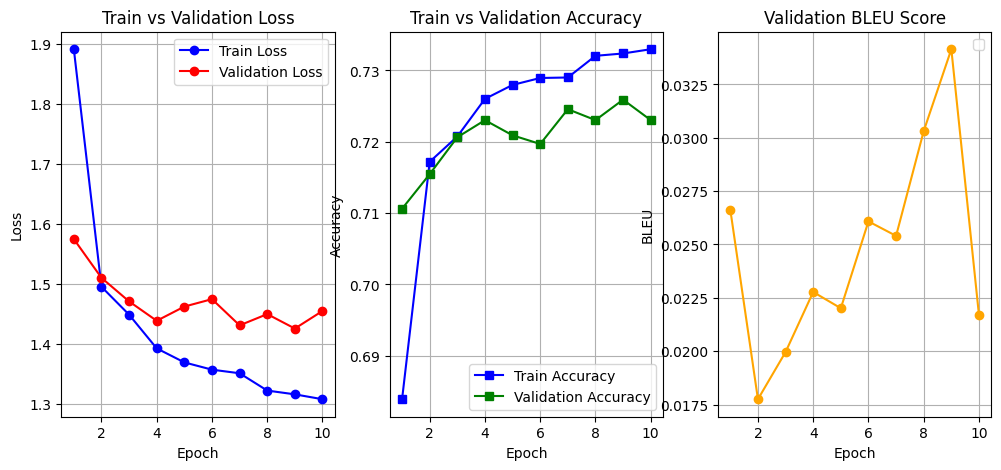

In [44]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o', color='blue')
plt.plot(epochs, history["valid_loss"], label="Validation Loss", marker='o', color='red')
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history["train_accuracy"], label="Train Accuracy", marker='s', color='blue')
plt.plot(epochs, history["valid_accuracy"], label="Validation Accuracy", marker='s', color='green')
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, history["valid_bleu"], marker='o', color='orange')
plt.title("Validation BLEU Score")
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.legend()
plt.grid(True)

#### ⚡ Bleu metric
---

In [41]:
bleu_metric = BLEUMetric(tokenizer=tokenizer)

test_dataset, _ = generate_tf_dataset(
    test_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=False
)

test_loss, test_accuracy, test_bleu = [], [], []
for ti, t_batch in enumerate(test_dataset):
    print(f"{ti+1} batches processed", end='\r')
    loss, accuracy = full_model.test_on_batch(t_batch[0], t_batch[1])
    batch_predicted = full_model.predict_on_batch(t_batch[0])
    bleu_score = bleu_metric.calculate_bleu_from_predictions(t_batch[1], batch_predicted)
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    test_bleu.append(bleu_score)

print(
    f"\ntest_loss: {np.mean(test_loss)} - test_accuracy: {np.mean(test_accuracy)} - test_bleu: {np.mean(test_bleu)}"
)

KeyboardInterrupt: 

#### ⚡ Generate random samples. 
---

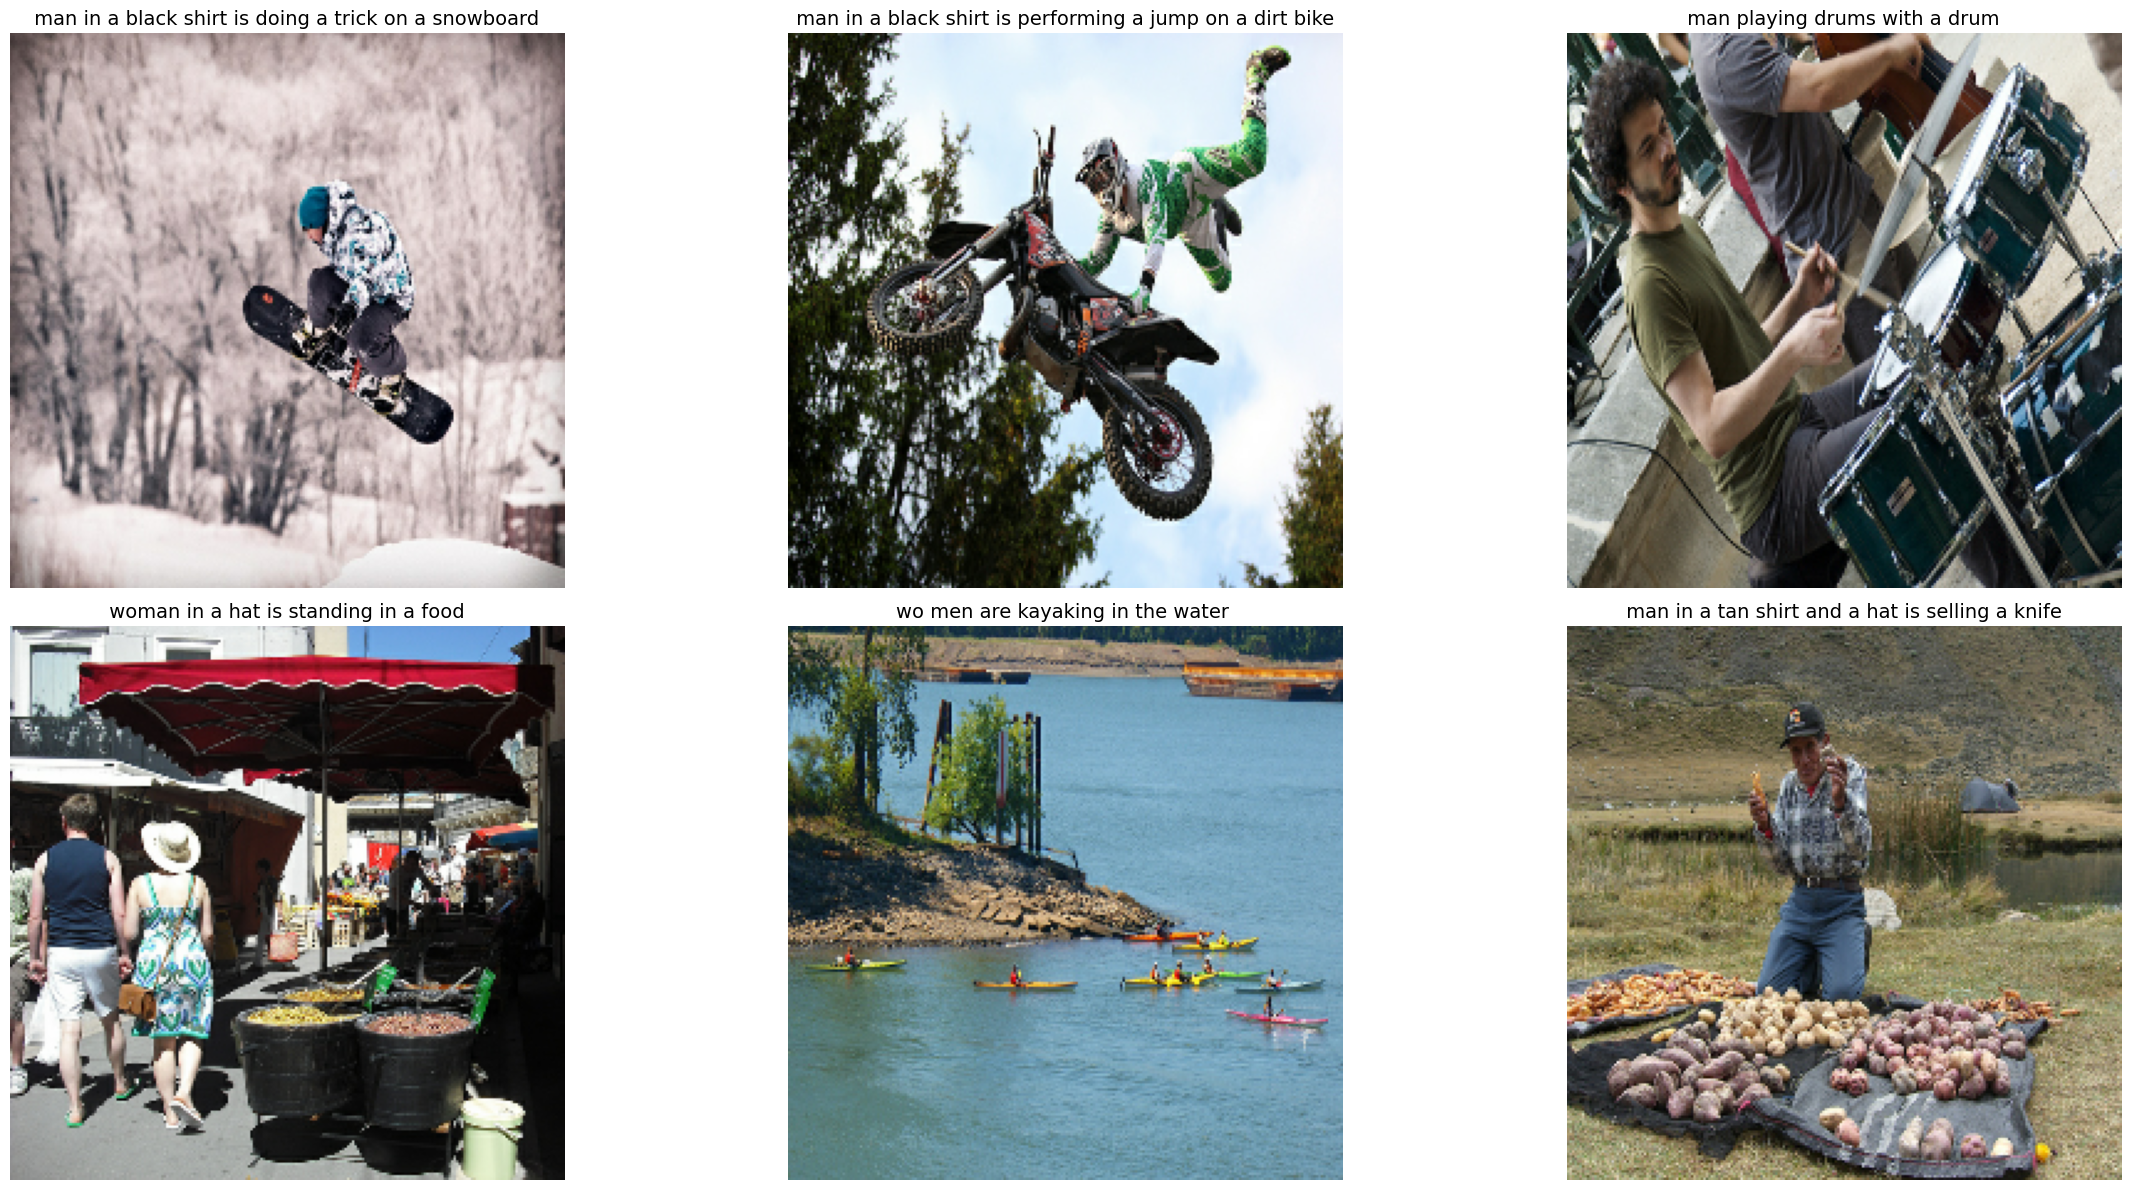

In [56]:
# === Parameters ===
n_samples = 6

# === Prepare Test Dataset ===
test_dataset, _ = generate_tf_dataset(
    test_df.sample(n=n_samples),
    tokenizer=tokenizer,
    n_vocab=n_vocab,
    batch_size=n_samples,
    training=False
)

# === Caption Generation ===
def generate_caption(model, image_input, tokenizer, n_samples):
    batch_tokens = np.repeat(np.array([[2]]), n_samples, axis=0)  # [START]
    
    for i in range(30):
        if np.all(batch_tokens[:, -1] == 3):  # [END]
            break
        position_input = tf.repeat(tf.reshape(tf.range(i + 1), [1, -1]), n_samples, axis=0)
        probs = model((image_input, batch_tokens, position_input)).numpy()
        batch_tokens = np.argmax(probs, axis=-1)
    
    predicted_text = []
    for sample_tokens in batch_tokens:
        tokens = []
        for wid in sample_tokens:
            tok = tokenizer.id_to_token(wid)
            tokens.append(tok)
            if wid == 3:  # [END]
                break
        text = " ".join(tokens).replace(" ##", "")
        predicted_text.append(text)
    
    return predicted_text

# === Run Inference ===
for batch in test_dataset.take(1):
    (batch_image_input, _, _), _ = batch

batch_predicted_text = generate_caption(full_model, batch_image_input, tokenizer, n_samples)

# === Display Results: Bigger Images, Smaller Text ===
num_cols = 3
num_rows = (n_samples + num_cols - 1) // num_cols
plt.figure(figsize=(25, 6 * num_rows))  # Larger images

for i in range(n_samples):
    img = batch_image_input[i].numpy()
    img = (img + 1.0) / 2.0  # Normalize to [0, 1]
    
    caption = batch_predicted_text[i]
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.title(caption[9:-5], fontsize=14)  # Smaller text
    plt.axis("off")

plt.tight_layout()
plt.show()


# TEST_IMAGES

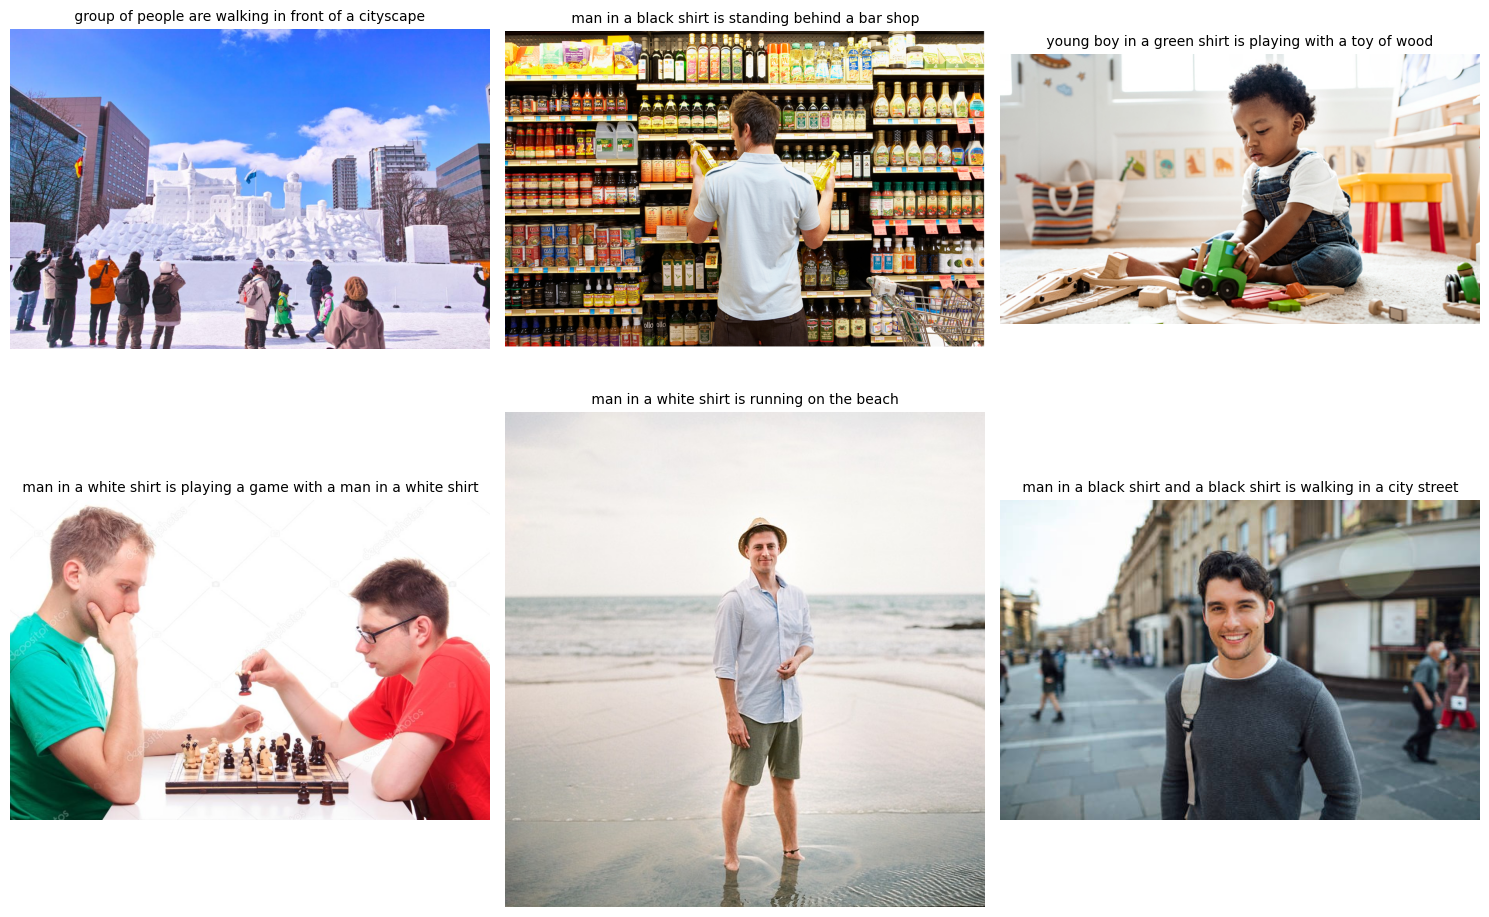

In [ ]:
# === Preprocess Function ===
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = (img_array / 127.5) - 1.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# === Caption Generation Function ===
def generate_captionn(model, image_input, tokenizer):
    batch_tokens = np.repeat(np.array([[2]]), 1, axis=0)  
    for i in range(74):
        if np.all(batch_tokens[:, -1] == 3):  
            break
        position_input = tf.repeat(tf.reshape(tf.range(i + 1), [1, -1]), 1, axis=0)
        probs = model((image_input, batch_tokens, position_input)).numpy()
        batch_tokens = np.argmax(probs, axis=-1)
    
    predicted_text = []
    for sample_tokens in batch_tokens:
        tokens = []
        for wid in sample_tokens:
            tokens.append(tokenizer.id_to_token(wid))
            if wid == 3:  # [END]
                break
        text = " ".join(tokens).replace(" ##", "")
        predicted_text.append(text)
    return predicted_text

# === Load Image Folder ===
image_folder = "/kaggle/input/test-images/TEST_IMAGES" 
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# === Generate Captions ===
captions = []
for filename in image_files:
    img_path = os.path.join(image_folder, filename)
    img = Image.open(img_path).convert("RGB")
    preprocessed_img = preprocess_image(img_path)

    caption = generate_captionn(full_model, preprocessed_img, tokenizer)[0]
    captions.append((filename, img, caption))

# === Display Captions Nicely ===
num_cols = 3
num_rows = (len(captions) + num_cols - 1) // num_cols
plt.figure(figsize=(15, 5 * num_rows))

for i, (filename, image, caption) in enumerate(captions):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)
    plt.title(caption[9:-5], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
